# Optimering project 1

##### Libraries

In [28]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)
import time

In [29]:
def plotUnitBalls(pnorm, N = 1000):
    grid = np.zeros((N,N))
    r = N/4 #Assume the grid is [-2,2]x[-2,2], then r = N/4 represent the radis of 1.
    for i in range(N):
        for j in range(N):
            if np.linalg.norm(np.array([i - N/2, j - N/2]), ord = pnorm) < r:
                grid[i,j] = 1
    return grid

In [48]:
N = 100
norms = [1,2, np.inf]
M = len(norms)
unitballs = np.zeros((M,N,N))
for count, norm in enumerate(norms):
    unitballs[count] = plotUnitBalls(norm, N)


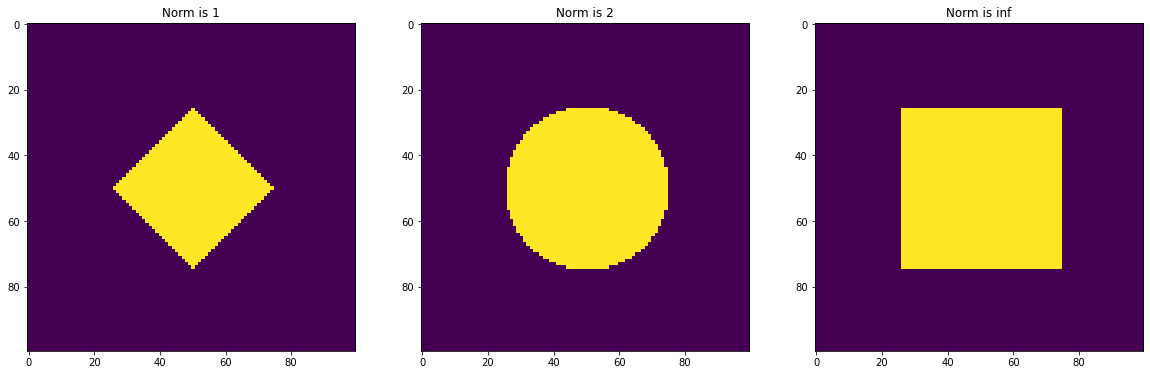

In [49]:
fig, ax = plt.subplots(1,M, figsize = (20,20))
for i in range(M):
    ax[i].set_title(f"Norm is {norms[i]}")
    ax[i].imshow(unitballs[i])
    
    
    
    

In [32]:
def Weiszfeld(P, v, tol = 1E-8, iter_limit = 1000):
    
    '''
    Parameters
    ----------
    P : list of points to minimize distance from
    v : weights of each point
    tol : TYPE, optional
        DESCRIPTION. The default is 1e-8.
    iter_limit : Failsafe iteration limit

    Returns
    -------
    x: approximated optimum
    count/error : iterationsteps if the method converges, error if not

    '''
    M = len(v)
    x = []
    Test = np.zeros(M)
    
    """Testing if minimum is attained in P"""
    for k in range(M):
        zum1, zum2 = 0, 0
        for i in range(M):
            if i == k:
                continue
            zum1 += v[i]*(P[k,0] - P[i,0])/np.linalg.norm(P[k] - P[i])
            zum2 += v[i]*(P[k,1] - P[i,1])/np.linalg.norm(P[k] - P[i])
        Test[k] = np.sqrt((zum1**2 + zum2**2))
    
    for k, test_k in enumerate(Test):
        if test_k <= v[k]:
            return [P[k]], 0
    else:
        euclidMed = P.sum(axis=0)/len(P) #Shown in PDF
        x.append(euclidMed)
    
    
    """Begining iteration process"""
    rel_error = np.inf
    count = 0
    while rel_error > tol:
        count += 1
        zum1, zum2, zum3, f, Df = 0, 0, 0, 0, np.zeros(2)
        x.append(np.zeros(2))
        xprev = x[-2]
        for i in range(M):
            zum1 += v[i]*P[i,0]/np.linalg.norm(P[i] - xprev)
            zum2 += v[i]*P[i,1]/np.linalg.norm(P[i] - xprev)
            zum3 += v[i]/np.linalg.norm(P[i] - xprev)
        """Calculating stopping critera by relative error"""
        x[-1] = np.array([zum1/zum3,zum2/zum3])
        x_current = x[-1]
        for i in range(M):
            f += v[i]*np.linalg.norm(P[i] - x_current)
            Df +=  v[i] * (P[i] - x_current)/np.linalg.norm(P[i] - x_current) 
        x_vec = np.tile(x[-1], M).transpose()
        sigma = np.zeros(M)
        for i in range(M):
            sigma[i] = np.linalg.norm(x_vec[i] - P[i])
        sigma = np.max(sigma)
        Df_max = max(Df)
        #Df_max = np.linalg.norm(Df)
        rel_error = abs((Df_max*sigma) / (f - Df_max*sigma))
        
        """Failsave iter limit"""
        if count > iter_limit:
            print("Weiszfeld iterlimit reached")
            break
            
    """Return thelist of iteration points"""
    x_final = np.zeros((count+1,2))
    for i, x_i in enumerate(x):
        x_final[i] = np.array(x_i).flatten()
    return x_final, rel_error
        
        
    

In [33]:
#%% Step control
def chooseStep(xk, pk, f, Df, P, v, a=1, rho = 0.5, c1=0.5):
    '''
    Parameters
    ----------
    xk : curent iteration point
    pk : descent direction
    f : objective function
    Df : gradient
    a : initial step size. The default is 1.
    rho : step-adjustment factor. The default is 0.5.
    c1 : Armijo-parameter. The default is 0.5.

    Returns
    -------
    a : step size satisfying te Armijo condtition.
    '''
    count = 0
    while (f(xk + a*pk, P, v) > f(xk, P, v) + c1*a*Df(xk, P, v).dot(pk)):
        a = a*rho
        count += 1
    return a

#%% Gradient descent

def gradDescent(f, Df, P, v,  a=1, rho=0.5, c1 = 0.5, backTrack=True, tol=1e-8, iter_limit = 1000):
    '''
    Parameters
    ----------
    f : objective function
    Df : gradient
    x0 : initial guess.
    a : default step size. The default is 1.
    rho : step-adjustment factor. The default is 0.5.
    c1 : Armijo-parameter. The default is 0.5.
    backTrack : Bool. True if backtracking is required. The default is True.
    tol : TYPE, optional
        DESCRIPTION. The default is 1e-8.
    retSteps : Bool. True if number of steps should be returned The default is False.

    Returns
    -------
    x: approximated optimum
    count/error : iterationsteps if the method converges, error if not

    '''
    xprev = np.inf
    p = 0
    M = len(v)
    x = []
    Test = np.zeros(M)
    
    
    """Testing if minimum is attained in P"""
    for k in range(M):
        zum1, zum2 = 0, 0
        for i in range(M):
            if i == k:
                continue
            zum1 += v[i]*(P[k,0] - P[i,0])/np.linalg.norm(P[k] - P[i])
            zum2 += v[i]*(P[k,1] - P[i,1])/np.linalg.norm(P[k] - P[i])
        Test[k] = np.sqrt((zum1**2 + zum2**2))
    
    for k, test_k in enumerate(Test):
        if test_k <= v[k]:
            return [P[k]], 0
    else:
        euclidMed = P.sum(axis=0)/len(P) #Shown in PDF
        x.append(euclidMed)
        
    rel_error = np.inf   
    descent_error = np.inf
    count = 0
    """Gradient descent with backtracking iteration"""
    while(rel_error > tol): #continue while gradient norm is above tolerance
        x.append(np.zeros(2))
        count += 1
        xprev = x[-2]
        Dfprev = Df(xprev, P, v)
        p = -Dfprev #compute direction (negative gradient)
        if backTrack:
            a = chooseStep(xk = xprev, pk = p, f = f, Df = Df, a = a, P = P, v = v, c1 = c1, rho = rho) #choose a good step size
        x[-1] = (xprev + a*p)     #iterate
        """Calculating stopping critera by relative error"""
        Dfval =  Df(x[-1], P, v)
        fval = f(x[-1], P, v)
        descent_error = np.linalg.norm(Dfval)
        """ Here the absolute error intitaly used as stoppingcriteria in the gradient descent got changed to relative error by dividing with the function value, such that the two models could be commensurable
        and such better be compared."""
        rel_error = descent_error/fval #Both are always positive
        if count > iter_limit:
            print("grad descent iterlimit reached")
            break
    x_final = np.zeros((count+1,2))
    for i, x_i in enumerate(x):
        x_final[i] = np.array(x_i).flatten()
    return x_final, descent_error

In [34]:
def f(x, P, v):
    fval = 0
    for i in range(len(v)):
        fval += v[i]*np.linalg.norm(P[i] - x)
    return fval

def Df(x, P, v):
    Dfval = 0
    for i in range(len(v)):
        numerator = v[i]*(P[i] - x)
        denominator = np.linalg.norm(P[i] - x)
        Dfval += numerator/denominator
    #Dfval = (v*(P - np.tile(x, len(v))/(np.linalg.norm(P - x)))).sum(axis = 1)
    return -Dfval

In [35]:
N = 10
P = np.random.uniform(0,1,N*2)
P = P.reshape((N,2))
v = np.random.uniform(0.1,1,len(P))
tol = 1E-7

In [36]:
x, rel_error_x = Weiszfeld(P, v, tol = tol, iter_limit = 10000)
print(f" Weiszfeld needed {len(x)} iterations to reach tolerance of {tol}, with relative error of {rel_error_x}")

 Weiszfeld needed 28 iterations to reach tolerance of 1e-07, with relative error of 8.594708014318026e-08


In [37]:
y, rel_error_y = gradDescent(f, Df, P, v, tol = tol, iter_limit = 10000, c1 = 0.5)
print(f" Gradient descent needed {len(y)} iterations to reach tolerance of {tol}, with absolute error of {rel_error_y}")

 Gradient descent needed 16 iterations to reach tolerance of 1e-07, with absolute error of 2.0571771809800407e-07


[0.53 0.57]
[0.53 0.57]


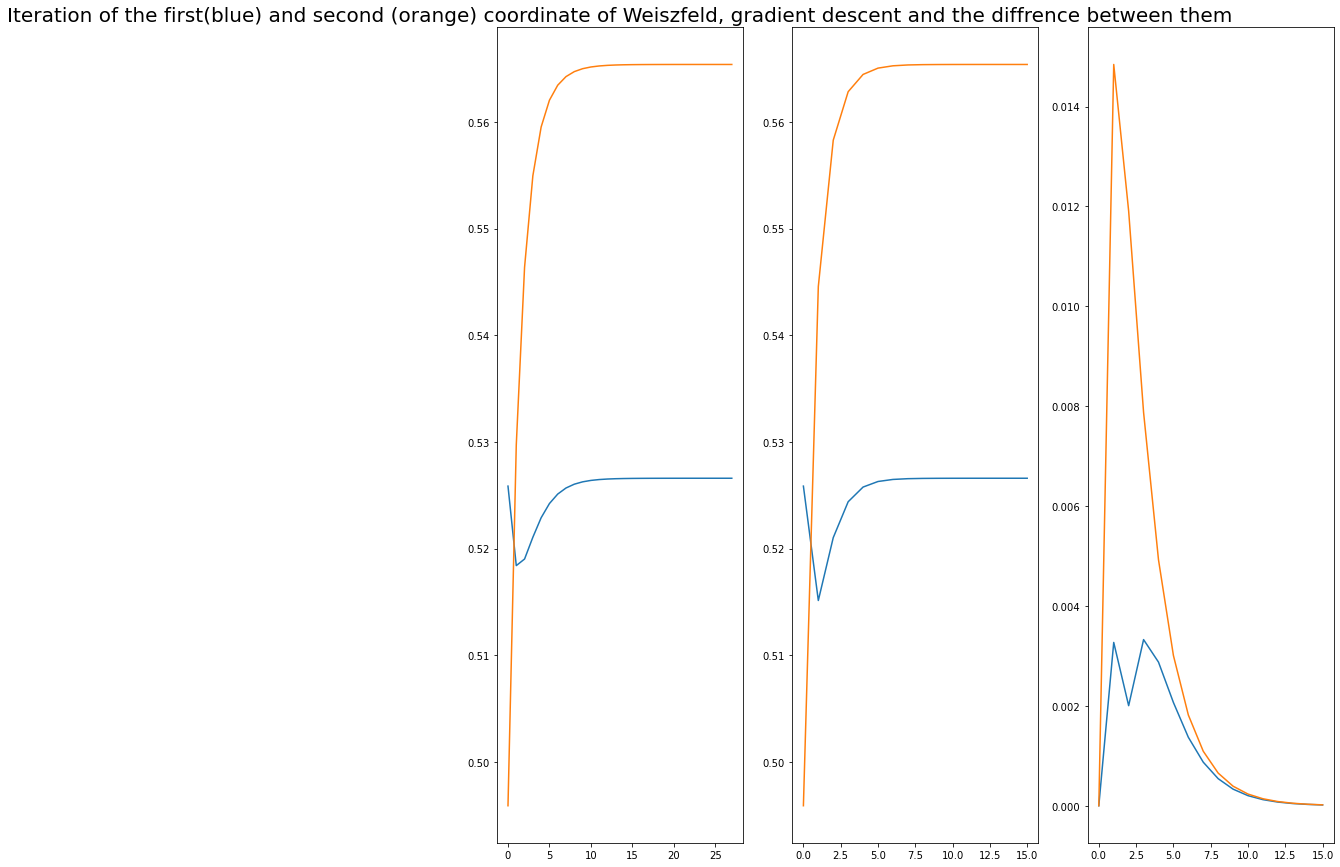

In [38]:
fix, ax = plt.subplots(1, 3,figsize = (15,15))
plot_limit = 50
plot_limit_x = min(plot_limit,len(x))
plot_limit_y = min(plot_limit,len(y))
ax[0].plot(np.array(range(len(x[:plot_limit_x]))), x[:plot_limit_x])
ax[0].set_title("Iteration of the first(blue) and second (orange) coordinate of Weiszfeld, gradient descent and the diffrence between them", size = 20)
ax[1].plot(np.array(range(len(y[:plot_limit_y]))), y[:plot_limit_y])
minlen = min(len(x), len(y))
error = np.abs(x[:minlen] - y[:minlen])
print(x[-1])
print(y[-1])
ax[2].plot(np.array(range(len(error[:plot_limit]))), error[:plot_limit])

Checking the minuimum values are the same. 

In [39]:
print(f(x[-1], P, v))
print(f(y[-1], P, v))
print(np.linalg.norm(f(y[-1], P, v) - f(x[-1], P, v)))

2.5100382210603325
2.5100382210603223
1.021405182655144e-14


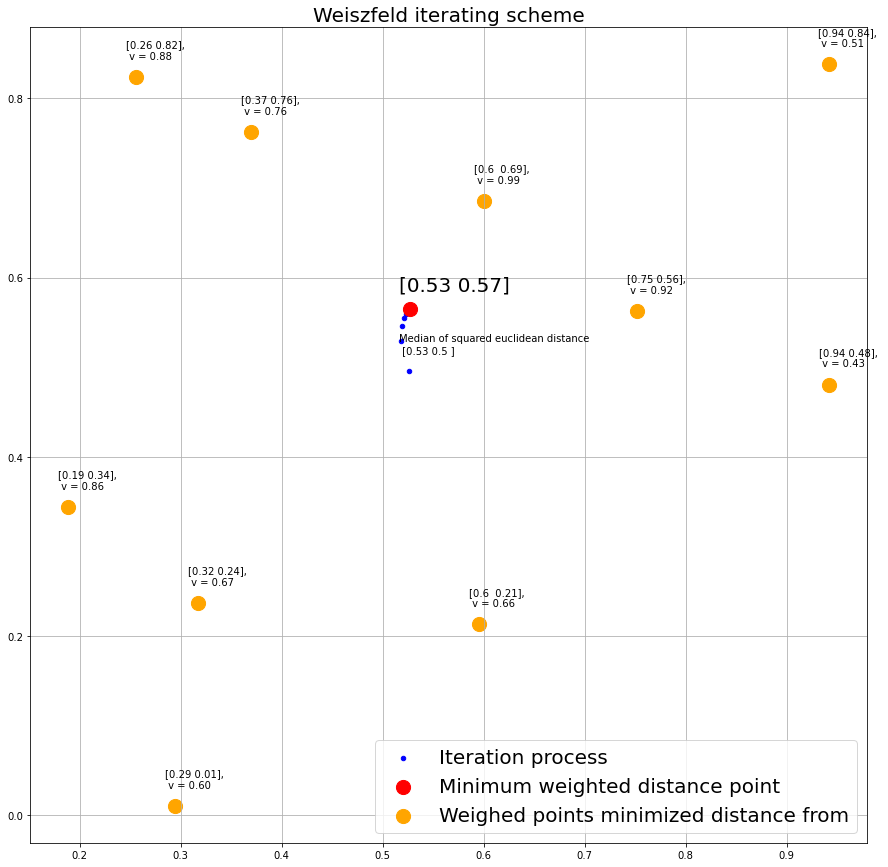

In [40]:
fig, ax = plt.subplots(figsize = (15,15))
ax.set_title("Weiszfeld iterating scheme", size = 20)
for i in range(len(x) + N):
    if i < len(x) - 1:
        if i == 0:
            ax.scatter(x[i,0], x[i,1], s = 20, c = "blue", label = "Iteration process")
            ax.annotate(f"Median of squared euclidean distance \n {x[i]}", x[i], xytext = x[i] + np.array([-0.01,0.02]), size = 10)
        else:
            ax.scatter(x[i,0], x[i,1], s = 20, c = "blue")
    elif i == len(x) - 1:
        ax.scatter(x[i,0], x[i,1], s = 200, c = "red", label = "Minimum weighted distance point")
        ax.annotate(f"{x[i]}", x[i],xytext = x[i] + np.array([-0.01,0.02]), size = 20)
    else:
        j = i - len(x)
        if j == 0:
            ax.scatter(P[j,0], P[j,1], s = 200, c = "orange", label = "Weighed points minimized distance from")
            ax.annotate(f"{P[j]}, \n v = {v[j]:.2f}", P[j],xytext = P[j] + np.array([-0.01,0.02]), size = 10)
        else:
            ax.scatter(P[j,0], P[j,1], s = 200, c = "orange")
            ax.annotate(f"{P[j]}, \n v = {v[j]:.2f}", P[j],xytext = P[j] + np.array([-0.01,0.02]), size = 10)
ax.legend(prop={'size': 20})
ax.grid()

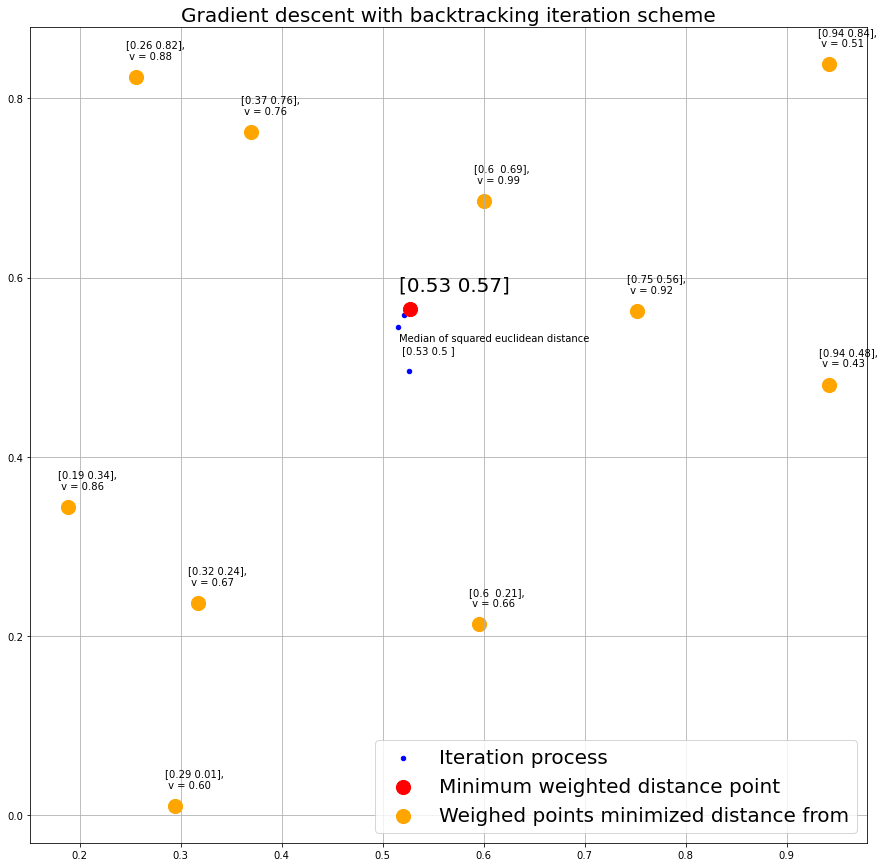

In [41]:
fig, ax = plt.subplots(figsize = (15,15))
ax.set_title("Gradient descent with backtracking iteration scheme", size = 20)
for i in range(len(y) + N):
    if i < len(y) - 1:
        if i == 0:
            ax.scatter(y[i,0], y[i,1], s = 20, c = "blue", label = "Iteration process")
            ax.annotate(f"Median of squared euclidean distance \n {y[i]}", y[i], xytext = y[i] + np.array([-0.01,0.02]), size = 10)
        else:
            ax.scatter(y[i,0], y[i,1], s = 20, c = "blue")
    elif i == len(y) - 1:
        ax.scatter(y[i,0], y[i,1], s = 200, c = "red", label = "Minimum weighted distance point")
        ax.annotate(f"{y[i]}", y[i],xytext = y[i] + np.array([-0.01,0.02]), size = 20)
    else:
        j = i - len(y)
        if j == 0:
            ax.scatter(P[j,0], P[j,1], s = 200, c = "orange", label = "Weighed points minimized distance from")
            ax.annotate(f"{P[j]}, \n v = {v[j]:.2f}", P[j],xytext = P[j] + np.array([-0.01,0.02]), size = 10)
        else:
            ax.scatter(P[j,0], P[j,1], s = 200, c = "orange")
            ax.annotate(f"{P[j]}, \n v = {v[j]:.2f}", P[j],xytext = P[j] + np.array([-0.01,0.02]), size = 10)
ax.legend(prop={'size': 20})
ax.grid()

### Comparisons sketch for latex documentation
Taking the relativ tolerance in both Weiszfeld and gradient descent with the armijo with diferent parameters, the former constently outperforms the latter with respect to running time, but looses with respect to the amount of iterations needed to satisfy the tolerance. Of course the former metric could always be improved by inserting more calculation every step, and the second depend on implementation to some degree. In this numerical solver the gradient descent takes functions as input, and does therefore a lot of function evaluations every iteration and stepsize finder loop, while Weiszfeld is implemented without f and Df as arguments, and both gets calculated in paralell in the same for-loop. This could make i go considerable faster if a lot of calls ere needed. Assuming the amount of functioncalls does not slow the gradient descent enough to make difference, the Weiszfeld does seem to work the best for this problem, and would therefor be recomended.

In [42]:
N = 130
P = np.random.uniform(0,1,N*2)
P = P.reshape((N,2))
v = np.random.uniform(0.1,1,len(P))
tol = 1E-6

t1W = time.time()
x, rel_error_x = Weiszfeld(P, v, tol)
dtW = time.time()- t1W

t1G = time.time()
y, rel_error_y = gradDescent(f, Df, P, v, tol = tol, iter_limit = 10000, backTrack = True, c1 = 0.5)
dtG = time.time() - t1G

print(f" Weiszfeld needed {round(dtW, 4)} seconds, {len(x)} iterations to reach tolerance of {tol}, with relative error of {rel_error_x}")
print(f" Gradient descent needed {round(dtG,4)} seconds, {len(y)} iterations to reach tolerance of {tol}, with relative error of {rel_error_y}")

 Weiszfeld needed 0.9201 seconds, 18 iterations to reach tolerance of 1e-06, with relative error of 7.192876883700576e-07
 Gradient descent needed 1.1111 seconds, 19 iterations to reach tolerance of 1e-06, with relative error of 1.8934169641271786e-05


In [43]:
M = 100
tol = 1E-5
dtW = np.zeros(M)
iterW = np.zeros(M)
dtG = np.zeros(M)
iterG = np.zeros(M)
for i in range(M):
    N = 130
    P = np.random.uniform(0,1,N*2)
    P = P.reshape((N,2))
    v = np.random.uniform(0.1,1,len(P))
    t1W = time.time()
    x, rel_error_x = Weiszfeld(P, v, tol)
    dtW[i] = time.time()- t1W
    iterW[i] = len(x)

    t1G = time.time()
    y, rel_error_y = gradDescent(f, Df, P, v, tol = tol, iter_limit = 10000, backTrack = True, c1 = 0.5)
    dtG[i] = time.time() - t1G
    iterG[i] = len(y)

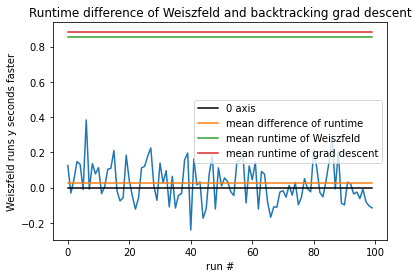

In [44]:
plt.figure()
plt.title("Runtime difference of Weiszfeld and backtracking grad descent")
plt.xlabel("run #")
plt.ylabel("Weiszfeld runs y seconds faster")
plt.plot(np.array(range(M)), dtG - dtW)
plt.plot(np.array(range(M)), np.zeros(M), label = "0 axis", color = "black")
plt.plot(np.array(range(M)), np.full(M, np.mean(dtG - dtW)), label = "mean difference of runtime")
plt.plot(np.array(range(M)), np.full(M, np.mean(dtW)), label = "mean runtime of Weiszfeld")
plt.plot(np.array(range(M)), np.full(M, np.mean(dtG)), label = "mean runtime of grad descent")
plt.legend()


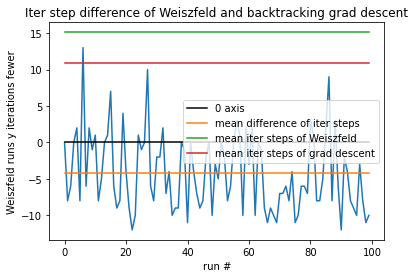

In [45]:
plt.figure()
plt.title("Iter step difference of Weiszfeld and backtracking grad descent")
plt.xlabel("run #")
plt.ylabel("Weiszfeld runs y iterations fewer")
plt.plot(np.array(range(M)), iterG - iterW)
plt.plot(np.array(range(M)), np.zeros(M), label = "0 axis", color = "black")
plt.plot(np.array(range(M)), np.full(M, np.mean(iterG - iterW)), label = "mean difference of iter steps")
plt.plot(np.array(range(M)), np.full(M, np.mean(iterW)), label = "mean iter steps of Weiszfeld")
plt.plot(np.array(range(M)), np.full(M, np.mean(iterG)), label = "mean iter steps of grad descent")
plt.legend()
